**02452** *Machine Learning*, Technical University of Denmark

- This Jupyter notebook contains exercises where you fill in missing code related to the lecture topic. *First*, try solving each task yourself. *Then* use the provided solution (an HTML file you can open in any web browser) as inspiration if needed. If you get stuck, ask a TA for help.

- Some tasks may be difficult or time-consuming - using the solution file or TA support is expected and perfectly fine, as long as you stay active and reflect on the solution.

- You are not expected to finish everything during the session. Prepare by looking at the exercises *before* the class, consult the TAs *during* class, and complete the remaining parts *at home*.

---

# Week 4: Probabilities, Bayes and naïve Bayes

**Content:** 
- Part 1: Understanding the Bernoulli distribution
- Part 2: Understanding the univariate Normal distribution
- Part 3: Understanding the multivariate Normal distribution
- Part 4: Bayes and naive Bayes classification
- Part 5: The `digits` data set

**Objective:**
- Understand the standard probability distributions and use them in modeling contexts.

In [149]:
import numpy as np
import collections
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

## Introduction - recap on basic probability theory in Python

In the first part of today's exercise, we review core concepts of probability theory and apply them using NumPy for simulation. We will have a closer look at joint, conditional probability and marginal probability, the law of total probability, independence and Bayes' theorem. The goal is to connect probability formulas to reproducible Python simulations, that we can use for modeling later on.

We consider a working example of students who just finished a machine learning (ML) course and let the events
- $A$ = student attended the lectures and exercises sessions during the course
- $P$ = student passed the final exam

#### Joint and conditional probabilities

The joint probability of two events $A$ and $P$ measures the likelihood that both events occur simultaneously, i.e.
$$
    P(A \cap P) = \text{probability that a student both attended and passed the exam.}
$$
Conditional probability measures the likelihood of one event given that the other has occurred. It is directly linked to the joint probability by division with the probability of one of the events, e.g.
$$
    P(A \mid P) = \frac{P(A \cap P)}{P(P)} \quad \Leftrightarrow \quad P(A \cap P) = P(A \mid P) P(P)
$$

After the exame, we asked students who passed and did not pass if they attended the course sessions. Say we got the following statistics:
- $P(P) = 0.75$
- $P(A \mid P) = 0.99$
- $P(A \mid \neg P) = 0.1$

**Task I.1:** Compute the joint probabilities $P(A, P)$ and $P(A, \neg P)$ using the formula. Additionally, simulate a class of $N = 600$ students and check that you get the correct quantities.

> *Hint:* Use `np.random.rand(N) < p` to generate attendance and exam outcomes.

> *Hint:* Use logical conditions like `&`, `|` and `~` to define events $P$ and $A$.

> *Hint:* Remember the complement rule stating that $P(\neg P) = 1 - P(P)$.

In [42]:
np.random.seed(42)
# Number of students
# A - atended classes
# P - passes exam

N = 600
P = 0.75
A_while_P = 0.99
A_while_not_P = 0.1

# YOUR CODE HERE
#Joint probability A & P
A_AND_P = A_while_P * P
#Joint probability A & ~P
A_NOT_P = A_while_not_P * (1-P)
print(f'P(P)={P:.2f}')
print(f'P(A|P)={A_while_P:.2f}')
print(f'P(A|~P)={A_while_not_P:.2f}')
print(f'P(A,P)={(A_AND_P):.2f}')
print(f'P(A,~P)={A_NOT_P:.2f}')

# Sim the model
# Generates N random numbers from (0, 1) and compares them to the P values. 
# Output is Bollean array with TRUE if <P and FALSE if >P.
Attendence_sim = np.random.rand(N) < P 
# Generates a random numbers from (0, 1) for each person who attended the class (sum of TRUE in A). 
# Output is a Bollean array of TRUE if <A_while_P and FALSE if >A_wile_P.
A_AND_P_sim = np.random.rand(Attendence_sim.sum()) < A_while_P
# Generates a random numbers from (0, 1) for each person who DID NOT attend the class (sum of FALSE in A)
# Output is a Bollean array of T <A_while_not_P and F >A_while_not_P.
A_NOT_P_sim = np.random.rand((~Attendence_sim).sum()) < A_while_not_P

# Mean gives us True / Total, which is probability
print(' ')
print(f'Simulated P(P)={np.mean(Attendence_sim):.2f}')
print(f'Simulated P(A|P)={np.mean(A_AND_P_sim):.2f}')
print(F'Simulated P(A|~P)={np.mean(A_NOT_P_sim):.2f}')
print(f'Simulated P(A,P)={np.mean(A_AND_P_sim) * np.mean(Attendence_sim):.2f}')
print(f'Simulated P(A,~P)={np.mean(A_NOT_P_sim) * (1-np.mean(Attendence_sim)):.2f}')

P(P)=0.75
P(A|P)=0.99
P(A|~P=0.10
P(A,P)=0.74
P(A,~P)=0.03
 
Simulated P(P)=0.73
Simulated P(A|P)=1.00
Simulated P(A|~P)=0.09
Simulated P(A,P)=0.73
Simulated P(A,~P)=0.02


As you see, re-running your code will give a different estimate of the empirical probabilities thus resembling variation in new semesters of students taking the course. When doing simulation-based experiments this is a bad property as it means that we are unable to reproduce the exact results seen once. Luckily, we can fix the pseudo-randomness in Python, thereby ensure reproducibility.

**Task I.2:** For some reason, the popularity of the course changed dramatically from one to another semester resulting in a total of $N=10{,}000$ registered course participants. Say our survey statistics about passing the exam and attending the course remain unchanged, how will this increase in students affect your simulation estimates?

- *Answer:* It will stay the same because we are drawing from normal distribution by using np.random.rand()

**Task I.3:** Use `np.random.seed()` to fix the pseudo-randomness. Verify that the estimated proabilities now remain unchanged when re-running the code. 

#### Law of Total Probability

In many scenarios, we are not able of directly measure the marginal probability of an event, e.g. $P(A)$. Measuring student attendence can be difficult, yet we do know the conditional probabilities of attending the course given pass/not pass from the follow-up survey. The law of total probability allows us to compute the marginal probability $P(A)$ by summing over mutually exclusive events $P_i$:
$$
    P(A) = \sum_i P(A \mid P_i) \, P(P_i) = P(A \mid P) \, P(P) + P(A \mid \neg P) \, P(\neg P) 
$$

**Task I.4:** Compute the total probability of attending the course, i.e. $P(A)$, using the law of total probability.

In [43]:
# YOUR CODE HERE
P_A = A_while_P * P + A_while_not_P * (1-P)
print(f'Total probability of attending the course P(A) is {P_A}.')

Total probability of attending the course P(A) is 0.7675.


#### Independence

The two events $A$ and $P$ are independent if knowing that one occurs does not change the probability of the other, i.e.
$$
    P(A \cap P) = P(A) \ P(P)
$$
Otherwise, the events are dependent.

**Task I.5:** Check if course attendance and passing the exam are independent using your previous calculation. Explain your result.

- *Answer:* The events are dependent. When we increase the probability of passing the exam, the attendance goes up and vice versa.

In [46]:
# We have to check if the joint probability of passing and attending is the same as the product of each
print(f"P(P, A) == P(P|A) * P(A) ? ==> {np.isclose(A_AND_P, P * P_A)}")

P(P, A) == P(P|A) * P(A) ? ==> False


#### Bayes' theorem

We now have all the building blocks for establishing Bayes’ theorem that allows us to reverse conditional probabilities, computing the probability of a cause given an observed effect, i.e.
$$
    P(P \mid A) = \frac{P(A \cap P)}{P(A)} = \frac{P(A \mid P)P(P)}{P(A)} = \frac{P(A \mid P) \ P(P)}{P(A \mid P) \, P(P) + P(A \mid \neg P) \, P(\neg P) }
$$
As you can see, Bayes' theorem uses the relation between the joint and conditional probability, the law of large numbers and the complement rule. Similarly we can use Bayes' theorem to compute the probability of a cause given not observing an effect, i.e.
$$
    P(P \mid \neg A) = \frac{P(\neg A \cap P)}{P(\neg A)} = \frac{P(\neg A \mid P)P(P)}{P(\neg A)} = \frac{(1 - P(A \mid P)) P(P)}{1 - P(A)} = \frac{(1 - P(A \mid P)) P(P)}{1 - P(A \mid P) \, P(P) + P(A \mid \neg P) \, P(\neg P) }
$$

**Task I.5:** Estimate the probabilities that:
1) a student passed given that they attended the course sessions.
2) a student passed given that they did not attend the course sessions.
3) a student did not pass given that they attended the course sessions.
4) a student did not pass given that they did not attend the course sessions. 

Based on your results, do you think it is generally a good idea to attend the course sessions?

> *Hint:* Again, remember the complement rule. It also works as $P(\neg P \mid A) = 1 - P(P \mid A)$.

In [60]:
# YOUR CODE HERE
# P(P|A) = P(A,P) / P(A)
P_while_A = A_AND_P / P_A
print(f'1) Probability of a student passed given that they attended the course sessions is {P_while_A:.2f}.')
# P(P|~A) = P(~A|P)*P(P) / P(A)
P_while_NOT_A = (1-A_while_P) * P / P_A
print(f'2) Probability of a student passed given that they DID NOT attend the course sessions is {P_while_NOT_A:.2f}.')
# P(~P|A) = P(A|~P)*P(P) / P(~A)
not_P_while_A = 1 - P_while_A
print(f'3) Probability of a student DID NOT pass given that they attended the course sessions is {not_P_while_A:.2f}.')
# P(~P|~A) = 1 - P(P|~A)
print(f'4) Probability of a student DID NOT pass given that they DID NOT attend the course sessions is {1 - P_while_NOT_A:.2f}.')

1) Probability of a student passed given that they attended the course sessions is 0.97.
2) Probability of a student passed given that they DID NOT attend the course sessions is 0.01.
3) Probability of a student DID NOT pass given that they attended the course sessions is 0.03.
4) Probability of a student DID NOT pass given that they DID NOT attend the course sessions is 0.99.


---

## Part 1: Understanding the Bernoulli distribution

The Bernoulli distribution models a random experiment with exactly two possible discrete outcomes - "success" (coded as 1) and "failure" (coded as 0) - and its' probability mass function (PMF) is
$$
    p(b|\theta) = \theta^b (1 - \theta)^{1-b}
$$
where $\theta \in [0,1]$ is the success rate. The Bernoulli distribution satisfies $p(b=1|\theta) = \theta$ and $p(b=0|\theta) = 1 - \theta$ and we can estimate the empirical success rate from $N$ samples, $\left[b_1, b_2, \dots b_N\right]$ as
$$
    \hat{p}\left({b=1}\right) = \frac{1}{N} \sum_{i=1}^N \mathbb{I}[b_i = 1]
$$
where $\mathbb{I}[\cdot]$ is the indicator function. If we run multiple independent Bernoulli experiments in a sequence, the resulting PMF distributes according to the [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution).

**Task 1.1:** Generate $N=200$ samples from a Bernoulli distribution with success rate $\theta=0.8$ and plot the samples.
> *Hint:* Use the function `np.random.binomial()`. The function takes the parameter `n` (the number of trials) as input - what is the proper value in our case?

**Task 1.2:** Compute the empirical probability mass function (PMF) for each possible outcome of $b$, i.e. $\hat{p}\left(b=0\right)$ and $\hat{p}\left(b=1 \right)$. Plot the results as a bar plot.
> *Hint:* Checkout `plt.bar()` for generating barplots.

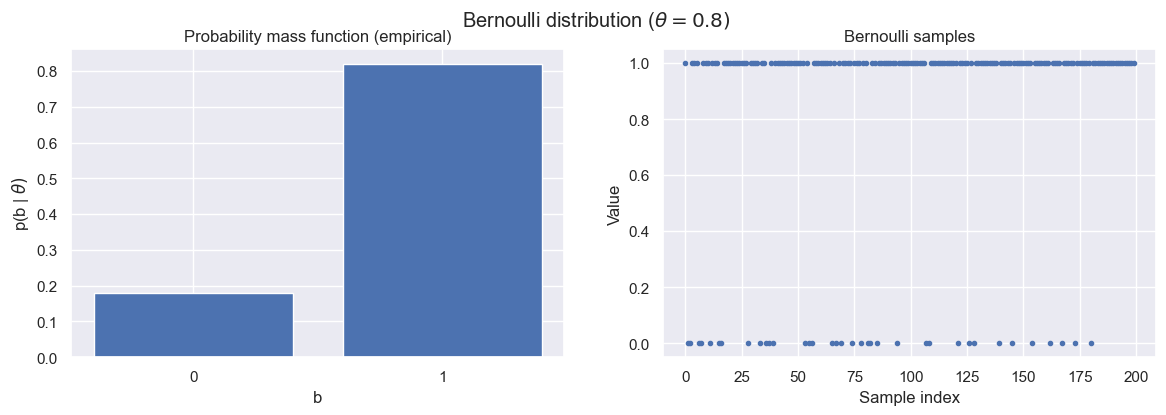

Empirical probability of success (b=1): 0.820
Theoretical probability of success (theta): 0.800


In [91]:
N = 200
p = 0.8
Bernouli_dist = np.random.binomial(1, p, N)
a = (Bernouli_dist == 0).sum() / N
b = (Bernouli_dist == 1).sum() / N

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle(r"Bernoulli distribution ($\theta=0.8)$")

axs[0].set_title('Probability mass function (empirical)')
axs[0].set_xlabel('b')
axs[0].set_ylabel(r'p(b | $\theta)$')
axs[0].bar(range(1,3), (a, b))
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['0','1'])

axs[1].set_title('Bernoulli samples')
axs[1].set_xlabel('Sample index')
axs[1].set_ylabel('Value')
axs[1].plot(Bernouli_dist, '.')

plt.show()

print(f"Empirical probability of success (b=1): {b:.3f}")
print(rf"Theoretical probability of success (theta): {p:.3f}")

**Task 1.3:** Argue why the empirical success rate $\hat{p}\left(b=1\right)$ is close but not equal to the theoretical succes rate $p\left(b=1|\theta\right)=\theta$ used to generate the samples.
- *Answer:* Because we are drawing finite sample size of 200. Closer we get to infinity, the closer to 0.8 w get. For example if N = 10,000, the empirical probability of sucess is 0.799.

<br>

---

## Part 2: Understanding the univariate Normal distribution

The Normal distribution - also known as the Gaussian distribution - is central to many methods in statistics and machine learning, both in its univariate and multivariate forms. It is a continuous probability distribution characterized by its bell-shaped curve and is fully defined by its mean, $\mu$, and variance, $\sigma^2$, which determine its center and spread. 

If a real-valued random variable $x\in\mathbb{R}$ is Normally distributed, its' probability density function (PDF) follows
$$
    \mathcal{N}\left(x|\mu, \sigma^2\right) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(- \frac{x - \mu^2}{2\sigma^2}\right)
$$
the empirical mean and variance of $N$ samples $x_1, x_2, \dots, x_N$ are given by:
$$
    \hat{\mu} = \frac{1}{N} \sum_{i=1}^N x_i \qquad \text{and} \qquad \hat{\sigma}^2 = \frac{1}{N-1} \sum_{i=1}^N (x_i - \hat{\mu})^2
$$

Here, $\hat{\mu}$ provides an estimate of the true mean $\mu$ of the underlying distribution, while $\hat{\sigma}^2$ is the empirical variance (using $N-1$ in the denominator for an unbiased estimate). These statistics summarize the central tendency and spread of the observed data. In practice, the empirical mean and variance will vary dependent on the drawn samples, but as $N$ increases, they converge to the true parameters of the distribution due to the [Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers).


**Task 2.1:** Generate $N=200$ samples from a Normal distribution with mean $\mu = 17$ and standard deviation $\sigma = 2$. Plot the samples and a histogram of the samples.
> *Hint:* the `np.random.normal()` function to learn how to generate Normal distributed random numbers in Python.

> *Hint:* use `plt.plot()` and `plt.hist()` to plot the samples and histogram.

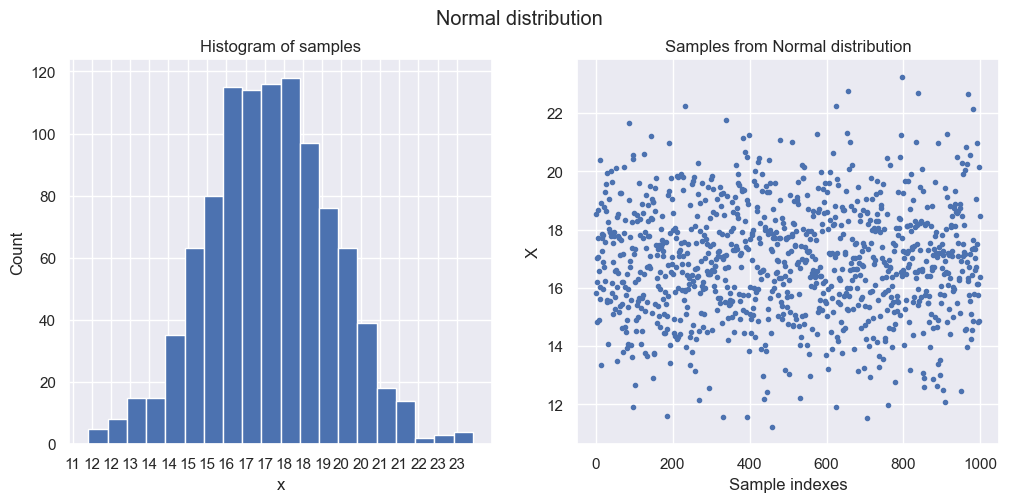

In [178]:
# Define parameters
N = 1000
mu = 17
sigma = 2

norm_dist = np.random.normal(mu, sigma, N)
fig, axs = plt.subplots(1,2, figsize = (12, 5))
fig.suptitle("Normal distribution")

axs[0].set_title('Histogram of samples')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Count')
_, bins, _ = axs[0].hist(norm_dist, bins=20, range=[np.min(norm_dist), np.max(norm_dist)])
axs[0].set_xticks(bins.round(2)-0.5)  # Optional: round for cleaner labels
axs[0].set_xticklabels([f"{b:.0f}" for b in bins])

axs[1].plot(norm_dist, '.')
axs[1].set_title('Samples from Normal distribution')
axs[1].set_xlabel('Sample indexes')
axs[1].set_ylabel('X')

plt.show()

**Task 2.2:** The histogram is generated by counting how many of the samples fall within the range covered by each bin of the histogram. Try changing the number of bins in the histogram.

**Task 2.3:** Compute the empirical mean and standard deviation of the generated samples. Show, that they are close but not equal to the theoretical values used to generate the random
samples.
> *Hint:* Take a look at the functions `np.mean()` and `np.std()`

**Task 2.4:** Try running the code a few times and see how the empirical mean and standard deviation changes when new random numbers are generated from the same distribution.
> *Hint:* Remember to re-run the previous cell where the data is generated !

In [179]:
mu_ = np.mean(norm_dist) 
sigma_ = np.std(norm_dist)
print(f'Empirical mean of the dataset is {mu_:.2f} and empirical standard deviation is {sigma_:.2f}.')
print(f'Theoretical mean of the dataset is {mu:.2f} and theoretical standard deviation is {sigma:.2f}.')


Empirical mean of the dataset is 16.91 and empirical standard deviation is 1.96.
Theoretical mean of the dataset is 17.00 and theoretical standard deviation is 2.00.


**Task 2.5:** Plot the empirical mean, theoretical mean and true probability density function (PDF) on top of your histogram.
> *Hint:* Take a look at the function `scipy.stats.norm.pdf()` and `plt.axvline()`

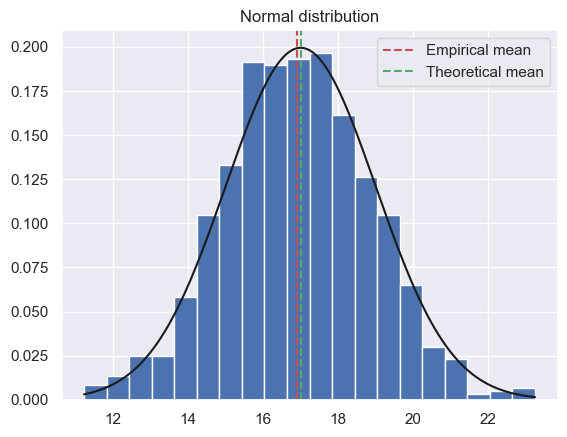

In [180]:


# Plot the histogram
fig = plt.figure()
plt.title("Normal distribution")
plt.hist(norm_dist, bins=20, density=True)

# Over the histogram, plot the theoretical probability distribution function:
x = np.linspace(norm_dist.min(), norm_dist.max(), N)
pdf = stats.norm.pdf(x, loc=17, scale=2)
plt.plot(x, pdf, "-", color="k")

# Plot the empirical mean and theoretical mean
plt.axvline(mu_, color='r', linestyle='--', label='Empirical mean')
plt.axvline(mu, color='g', linestyle='--', label='Theoretical mean')
plt.legend()
plt.show()    

**Task 2.6:** Show that when the number of samples $N$ is increased, the histogram approximates the pdf better and the empirical estimates of the mean and standard deviation improve.


#### The Central Limit Theorem
One reason that the Normal distribution is central in machine learning is due to the **Central Limit Theorem (CLT)**. The CLT states that the sample mean $\bar{x} = \frac{1}{N} \sum_i^N x_i$ of a collection of i.i.d. random variables, $\mathcal{S}=\{x_i\}_{i=1}^N$, follows a Normal distribution for large sample size $N$. This holds for any data-generating distribution, i.e. $x_i \sim p\left(\mu,\sigma^2\right)$, with mean $\mu$ and finite variance $\sigma^2$. The sample mean is indeed a random variable itself, as it depends on the specific realization of $\mathcal{S}$. Specifically, the CLT states that
$$
\bar{x} \sim \mathcal{N}\left(\mu, \frac{\sigma^2}{N}\right)
$$
for large $N$. This allows us to easily make statistical inference such as providing uncertainty estimates even if the original data distribution is nowhere near being Gaussian. In the following exercise, we will give a simulation-based "proof" that this is indeed true using the continuous uniform distribution for generating the sample collection, i.e. $x_i \sim \operatorname{Uniform}(0,1)$. 

**Task 2.7:** Generate $N=50$ samples from $\operatorname{Uniform}(a,b)$ and compute the sample mean, $\bar{x}$. Plot the samples as a histogram.
> *Hint:* Use `np.random.rand()` or `np.random.uniform()`.

**Task 2.8:** Repeat this computation to get $S=1000$ realizations of the sample mean. Plot this empirical sample mean distribution as a histogram. Plot the PDF of the Normal distribution with mean $\mu$ and variance $\frac{\sigma^2}{N}$ on top.
> *Hint:* The $\operatorname{Uniform}(a,b)$ distribution has mean $\mu=\frac{1}{2} (a + b)$ and variance $\sigma^2 = \frac{1}{12} (b-a)^2$. For other distributions, [see here](https://mathcs.clarku.edu/~djoyce/ma217/distributions2.pdf).

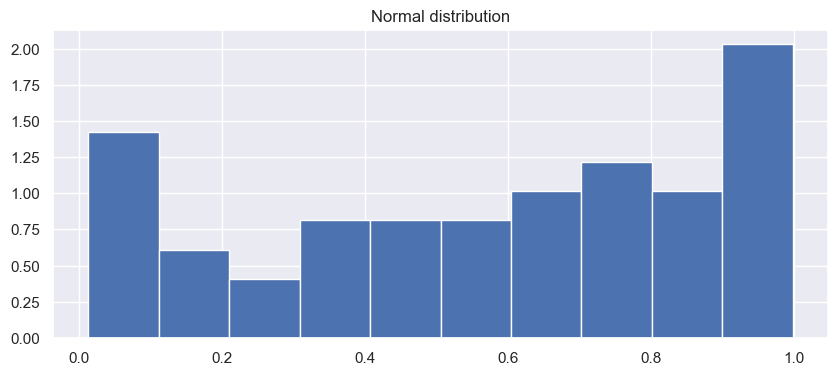

0.5734317518571443


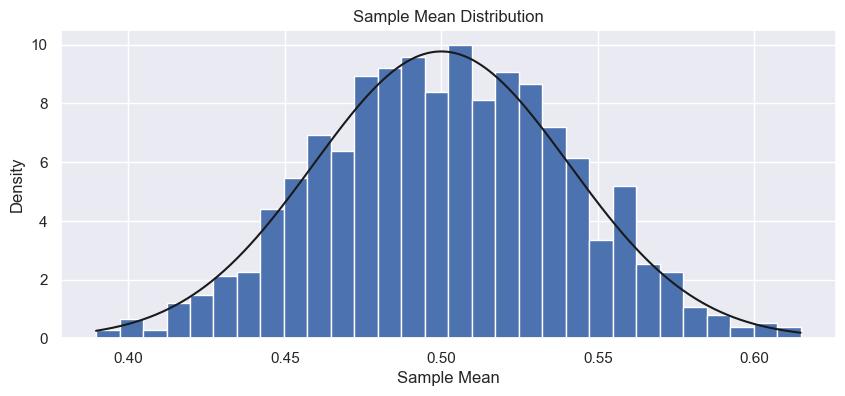

In [225]:
# Define parameters
N = 50
S = 1000
a = 0
b = 1

dist = np.random.uniform(a,b,(S,N))

# Plot the histogram
fig = plt.figure(figsize = (10,4))
plt.title("Normal distribution")
plt.hist(dist[0], bins=10, density=True)
plt.show()

print(np.mean(dist[0]))

sample_means = np.mean(dist, axis = 1)

# Plot the histogram
fig = plt.figure(figsize = (10,4))
plt.title("Normal distribution")
plt.hist(sample_means, bins=30, density=True)
plt.title("Sample Mean Distribution")
plt.xlabel("Sample Mean")
plt.ylabel("Density")

# Over the histogram, plot the theoretical probability distribution function:
x = np.linspace(sample_means.min(), sample_means.max(), S)
pdf = stats.norm.pdf(x, loc= 1/2*(a+b), scale=np.sqrt(1 / 12) * (b-a) / np.sqrt(N))
plt.plot(x, pdf, "-", color="k")

plt.show()

**Task 2.9:** Try to decrease the number of samples $N$. How does this affects the sample mean distribution? What happens if you modify the range of the uniform distribution?

**Optional:** Modify the data-generating distribution to any distribution you can think of. Does this choice impact the number of samples requires for the CLT to accurately describe the sample mean distribution? 

<br>

---

## Part 3: Understanding the multivariate Normal distribution

So far we have been considered a 1-dimensional Normal distributed random variable but we will now proceed to the *multivariate Normal distribution*. The probability density function (PDF) of the $M$-dimensional multivariate Normal distribution is
$$
    \mathcal{N}\left(\boldsymbol{x}|\boldsymbol{\mu}, \Sigma\right) = \frac{1}{\sqrt{\left(2\pi\right)^M \lvert \bf{\Sigma} \rvert}} \exp\left(-\frac{1}{2} \underbrace{\left(\boldsymbol{x} - \boldsymbol{\mu}\right)^\top \bf{\Sigma}^{-1} \left(\boldsymbol{x} - \boldsymbol{\mu}\right)}_{d} \right)
$$
where $\boldsymbol{\mu}=\left[\mu_1, \mu_2 \right]^\top$ is a vector containing the mean values for each dimension and $\bf{\Sigma}$ is the covariance matrix. Taking a closer look at the expression, we see that the leading term is $d=\left(\boldsymbol{x} - \boldsymbol{\mu}\right)^\top \bf{\Sigma}^{-1} \left(\boldsymbol{x} - \boldsymbol{\mu}\right)$ which is exactly the *Mahalanobis distance* that gives distances between a sample realization $\boldsymbol{x}$ and the mean $\boldsymbol{\mu}$ while respecting the covariance structure of the distribution through $\bf{\Sigma}^{-1}$. The bell-shape arises from applying the exponential to this distance. Note that the distribution with $\boldsymbol{\mu}=\bf{0}$ and $\bf{\Sigma} = I$ is called the *standard multivariate Normal distribution* for all dimensionalities $M$.

In the next step we will consider the multivariate Normal distribution in two dimensions. The covariance matrix for a 2D Gaussian is described by
$$
\bf{\Sigma } = \begin{bmatrix}
      \sigma _1^2 & \mathop{\rm cov} \left( x_1, x_2 \right)  \\
      \mathop{\rm cov} \left( x_2, x_1 \right) & \sigma _2^2
\end{bmatrix}
$$

where $\mathrm{cov}(\cdot,\cdot)$ is covariance between two random variables. Note that ${\mathop{\rm cov}} \left( { {x_1},{x_2}} \right) = {\mathop{\rm cov}}\left( { {x_2},{x_1}} \right)$, i.e., the covariance matrix is symmetric, and $\sigma_n^2={\mathop{\rm cov}}\left( { {x_n},{x_n}} \right)$. We can write the covariance matrix in terms of the correlation between attributes as
$$
      \mathop{\rm Correlation}\left( { {x_1},{x_2}} \right) = \frac{ {\mathop{\rm cov}} \left( { {x_1},{x_2}} \right)}{\sqrt{ {\mathop{\rm cov}} \left( { {x_1},{x_1}} \right)}\sqrt{ {\mathop{\rm cov}} \left( { {x_2},{x_2}} \right)}} \qquad \Leftrightarrow \qquad {\mathop{\rm cov}}\left( { {x_1},{x_2}} \right) = {\mathop{\rm Correlation}} \left( { {x_1},{x_2}} \right)\sqrt{ {\mathop{\rm cov}} \left( { {x_1},{x_1}} \right)}\sqrt{ {\mathop{\rm cov}} \left( { {x_2},{x_2}}\right) }.
$$

**Task 3.1:** Generate $N=1000$ samples from a 2-dimensional Normal distribution with mean $\boldsymbol{\mu}=\begin{bmatrix} 13 & 17 \end{bmatrix}$, $\sigma_1=2$, $\sigma_2=3$ and $\mathop{\rm{Correlation}}(x_1,x_2)=0.5$.
> *Hint:* Define the covariance matrix $\bf{\Sigma}$ from the given information.

> *Hint:* Look at the function `np.random.multivariate_normal()` to learn how you can generate multivariate Normal distributed random numbers in Python.

In [335]:
N = 1000
mu = np.array([13, 17])
sigma1 = 2
sigma2 = 3
cor_x1_x2 = 0.5
cov_matrix = np.matrix([
    [np.power(sigma1,2), cor_x1_x2*sigma1*sigma2],
    [cor_x1_x2*sigma2*sigma1, np.power(sigma2,2)]
])
norm_dist_2D = np.random.multivariate_normal(mu, cov_matrix, size = N)


**Task 3.2:** Plot the generated samples as a scatter plot as well as a 2-dimensional histogram. Choose a suitable number of histogram bins.
> *Hint:* Use `np.histogram2d()` or `plt.hist2d()` to create a 2-dimensional histogram.

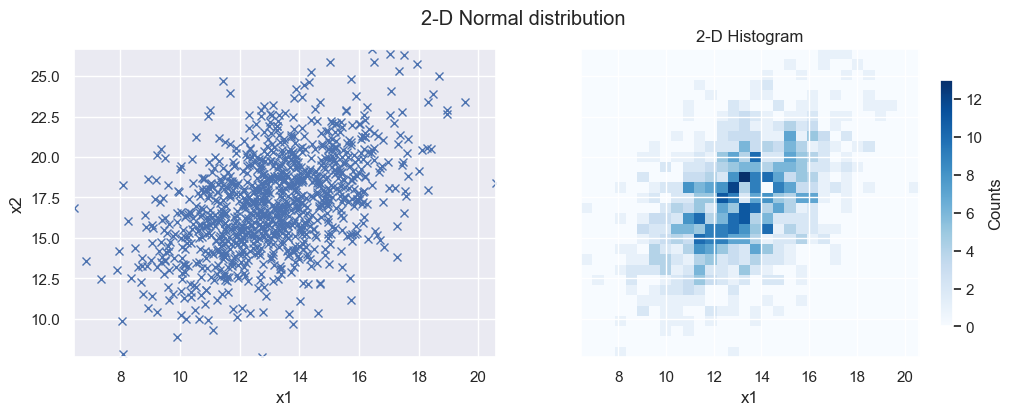

In [336]:
fig, axs = plt.subplots(1,2, figsize = (12,4), sharex = True, sharey = True)
fig.suptitle('2-D Normal distribution')

axs[0].plot(norm_dist_2D[:,0], norm_dist_2D[:,1], 'x')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
#axs[1].set_xlim(np.min(norm_dist_2D[:,0]-2), np.max(norm_dist_2D[:,0]+2)) # Set x-axis
#axs[1].set_ylim(np.min(norm_dist_2D[:,1]-2), np.max(norm_dist_2D[:,1]+2)) # Set y-axis 

H, xedges, yedges = np.histogram2d(norm_dist_2D[:,0], norm_dist_2D[:,1], bins=(30))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

axs[1].set_title('2-D Histogram')
axs[1].set_xlabel('x1')
hist_image = axs[1].imshow(H.T, cmap = 'Blues', origin = 'lower', extent=extent, aspect='auto')
fig.colorbar(hist_image,ax=axs[1], label = 'Counts', shrink = 0.8 )

plt.show()

**Task 3.3:** Show that when the correlation between $x_1$ and $x_2$ is zero, the scatter plot and 2-d histogram have the shape of an axis-aligned ellipse. Can you explain why?
- *Answer:* 

**Task 3.4:** Show that when the correlation between $x_1$ and $x_2$ is one, the values of $x_1$ and $x_2$ fall on a straight line. Can you explain why?
- *Answer:*

**Task 3.5:** Try varying the number of samples, the mean, the standard deviations, the correlation and the number of histogram bins and see what happens.

#### The Curse of Dimensionality

The **curse of dimensionality** describes a collection of phenomena that occur when working with data in high-dimensional spaces. As the number of dimensions, $M$, increases, the volume of the space grows exponentially, making data points increasingly far apart relative to the space - this means that the data becomes *sparse*. This sparsity has several important consequences:

- **Distance becomes less meaningful:** In high dimensions, the minimum and maximum pairwise distances between points become very similar, meaning that all points tend to be nearly equidistant from each other. This can cause problems for machine learning methods such as $k$-nearest neighbors and clustering techniques that rely on distance metrics.
- **Increased data and computation requirements:** To cover a high-dimensional space adequately, exponentially more data is needed. This raises both computational costs and the risk of overfitting, especially when training complex models on limited data (a topic we will explore further later on).

To explain this more precisely, consider a collection of $N$ data points $\{\boldsymbol{x}_i = \left[x_{i,1}, x_{i,2}, \dots, x_{i, M}\right]^\top\}_{i=1}^N$ drawn from an $M$-dimensional standard multivariate normal distribution, $\boldsymbol{x}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. 
The squared Euclidean norm of a single samples is given by $\|\boldsymbol{x}_i\|^2 = \sum_{j=1}^M x_{ij}^2$ which follows a $\chi^2(M)$ distribution. This distribution has mean $M$ and variance $2M$, so by the law of large numbers - stating that the sample mean converges to the true mean for large $N$ - the squared norm $\|\boldsymbol{x}_i\|^2$ concentrates around its expected value $M$. Consequently, the Euclidean norm $\|\boldsymbol{x}_i\|$ that represents the distance to origo, grows by $\sqrt{M}$ when increasing the dimensionality $M$. 

We will now explore a simple example to demonstrate these effects and discuss their implications for machine learning models.

**Task 3.6:** Generate $N=100$ samples from standard multivariate Normal distributions with dimensionalities $M \in [1, 10, 100, 1000]$. Compute the squared Euclidean distances to origo and summarize these through the mean and standard deviation for each dimensionality $M$.
> *Hint:* Store the results in variables `mean_distances` and `std_distances`. We use `plt.errorbar()` for plotting these results.

> *Hint:* Use `np.linalg.norm()` for computing the squared Euclidean distance.

> *Hint:* Verify that your results align with the theoretical expectation $\sqrt{M}$.

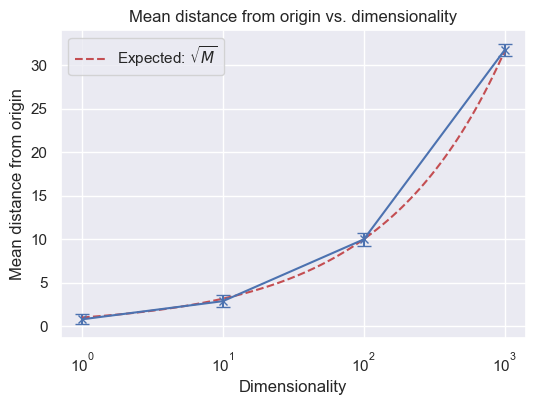

In [341]:
num_samples = 100
dims = [1, 10, 100, 1000]

distances = np.zeros((len(dims), num_samples))
for i,M in enumerate(dims):
    X = np.random.randn(num_samples, M)
    distances[i] = np.linalg.norm(X, axis = 1)

mean_distances = np.mean(distances, axis =1)
std_distances = np.std(distances, axis = 1)

fig = plt.figure(figsize=(6, 4))
plt.title('Mean distance from origin vs. dimensionality')
plt.errorbar(dims, mean_distances, yerr=std_distances, fmt='-x', capsize=5)
plt.plot(np.logspace(0, 3, 100), np.sqrt(np.logspace(0, 3, 100)), 'r--', label=r'Expected: $\sqrt{M}$')
plt.xlabel('Dimensionality')
plt.ylabel('Mean distance from origin')
plt.xscale('log')
plt.legend()
plt.show()

**Task 3.7:** Generate $N=100$ samples from standard multivariate Normal distributions with dimensionalities $M \in [1, 10, 100]$. For each dimensionality, compute the pairwise Euclidean distance matrix, $\bf{D}$, between samples and plot the results.
> *Hint:* The pairwise distance matrix can be computed with `scipy.spatial.distance.pdist()` and `scipy.spatial.distance.squareform()`.

> *Hint:* You can plot matrices using `plt.imshow()`.

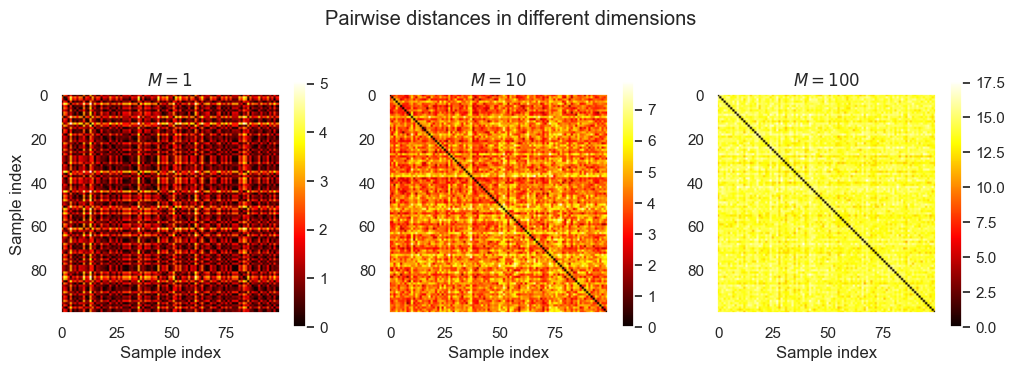

In [342]:
num_samples = 100
dims = [1, 10, 100]

fig, axs = plt.subplots(1, len(dims), figsize=(12, 4))
fig.suptitle('Pairwise distances in different dimensions')

# Loop through each dimensionality and compute pairwise distances
for i, M in enumerate(dims):
    X = np.random.randn(num_samples, M)     # generate samples in M dimensions
    D = squareform(pdist(X))                # compute pairwise distance matrix 
    
    # Plot the distance matrix
    img = axs[i].imshow(D, cmap='hot')
    fig.colorbar(img, ax=axs[i], shrink=0.8)
    axs[i].set_title(f'$M={M}$')
    axs[i].set_xlabel('Sample index')
    axs[i].grid(False)

axs[0].set_ylabel('Sample index')
plt.show()

**Task 3.8:** Based on the above experiments, what problems does the "curse of dimensionality" introduce in the context of the machine learning methods discussed in the course so far?
> *Hint:* What happens to the distance between points when you increase the dimensionality?

> *Hint:* Can you explain why, in high dimensions, the minimum and maximum pairwise distances between points get closer together?

> *Hint:* Why is this problematic for distance-based methods like $k$-nearest neighbors?

- *Answer:* 

**Task 3.9 (optional):** Try to read-through or re-implement [this exercise](https://www.geeksforgeeks.org/machine-learning/k-nearest-neighbors-and-curse-of-dimensionality/). The idea is to fit a $k$-nearest neighbor classifier on two data sets: 1) a high-dimensional image data and 2) a lower-dimensional version constructed using PCA. Which classifier performs best and why?

<br>

---

## Part 4: Bayes and Naive Bayes

We will now use our understanding of the previous distributions to examine two classifiers, namely a Bayesian classifier and a Naive Bayes classifier. Recall that the Bayesian classifier follows directly from Bayes' theorem:
$$
    p\left(y=c | \boldsymbol{x}\right) = \frac{p\left(\boldsymbol{x} | y=c\right) p(y=c)}{\sum_{k=0}^{K-1} p\left(\boldsymbol{x} | y=k\right) p(y=k)}
$$
where $K$ is the number of classes, $p\left(\boldsymbol{x}|y\right) = p\left(x_1, x_2, \dots, x_M | y\right)$ is the likelihood and $p(y)$ is the prior class information. The only difference between this Bayesian classifier and the Naive Bayes classifier, is the Naive Bayes assumption, stating independence of the likelihood terms given the label, i.e. $p\left(x_1, x_2, \dots, x_M | y\right) = p\left(x_1|y\right) p\left(x_2|y\right) \times \dots \times p\left(x_M|y\right)$. This results in a classifier of the following form:
$$
    p\left(y=c | \boldsymbol{x}\right) = \frac{p\left(x_1|y=c\right) p\left(x_2|y=c\right) \times \dots \times p\left(x_M|y=c\right) p(y=c)}{\sum_{k=0}^{K-1} p\left(x_1|y=k\right) p\left(x_2|y=k\right) \times \dots \times p\left(x_M|y=k\right) p(y=k)}
$$

In the next part of the exercise we will classify names as female or male names - for further details see also the `readme_male_female.txt` file in the associated data folder. 

We have a database with 2943 male names and 5001 female names. We will only consider names that contain at least four letters resulting in a total of $N^{\text{Male}} = 2785$ male and $N^{\text{Female}} = 4866$ female names.

**Task 4.1:** Examine and load the data files provided in the associated data folder. Filter the data to only consider names that contain at least four letters.
> *Hint:* Use `np.loadtxt()` to load txt-files. Be sure to set the `delimiter` correctly.

In [348]:
# Load male names from file
male_names = np.loadtxt('data/names/male.txt', dtype=str, delimiter='\\')
male_names = male_names[[len(name) >= 4 for name in male_names]]
# Or alternatively:
# male_names = male_names[np.char.str_len(male_names) >= 4]

# Load female names from file
female_names = np.loadtxt('data/names/female.txt', dtype=str, delimiter='\\')
female_names = female_names[[len(name) >= 4 for name in female_names]]
# Or alternatively:
# female_names = female_names[np.char.str_len(female_names) >= 4]

# Concatenate in a single array
names = np.concatenate((male_names, female_names))
### END SOLUTION

assert len(male_names) == 2785, "There should be 2785 male names!"
assert len(female_names) == 4866, "There should be 4866 female names!"

As feature for the classification we will use the first and second letter as well as the second last and last letter of the names denoted respectively $x_1$, $x_2$, $x_3$ and $x_4$. As an example, the name "Richard" will have $x_1=r$, $x_2=i$, $x_3=r$, $x_4=d$. Therefore, $x_i\in\{a,b,c,d,\ldots ,z\}$ such that each feature can take the value of any of the 26 letters of the alphabet (from a to z) hence the attributes used are discrete/categorical. In Python, we code each letter as a numbers between 1 and 26 where 1 corresponds to a and 26 to z.

**Task 4.2:** Inspect the following code that generates the data matrix $\boldsymbol{X}$ and binary target vector $\boldsymbol{y}$ with $y=0$ corresponding to male names and $y=1$ corresponding to female names.

In [349]:
# We construct a function that converts a name to a vector of letter indices.
# The vector will contain the indices of the first two and last two letters of the name.
def name2vector(name):
    """Convert a name to a vector of letter indices."""
    assert len(name) >= 4, "Name must have at least 4 characters!"
    name = name.strip().lower()
    return np.array([
        ord(name[0]) - ord("a") + 1,
        ord(name[1]) - ord("a") + 1,
        ord(name[-2]) - ord("a") + 1,
        ord(name[-1]) - ord("a") + 1
    ], dtype=int)

# Create the structure for the data matrix
X = np.zeros((len(names), 4), dtype=int)
# Create the target vector
y = np.concatenate([[0] * len(male_names) + [1] * len(female_names)]).reshape(-1,1)

# Loop through each name in the dataset
for i, name in enumerate(names):
    # Convert the name to a vector of letter indices
    letter_idxs = name2vector(name)
    # Fill the data matrix with letter indices
    X[i, :] = letter_idxs

assert X.shape == (7651, 4), "X should have shape (7651, 4)!"
assert y.shape == (7651, 1), "y should have shape (7651, 1)!"
assert np.all(np.isin(X, np.arange(1, 27))), "X should only contain values from 1 to 26!"


Using the formulation of a Bayesian classifier, we can classify a name as a female name if $p(y=1|x_1,x_2,x_3,x_4) > p(y=0|x_1,x_2,x_3,x_4)$ and as a male name otherwise. In order to classify names as male or female we need to compute our likelihood which is the number of times a given letter combination occurred for the male and female names, respectively. In other words we need to count how many times each of the letter combinations 
$$
\begin{align}
    (x_1,x_2,x_3,x_4) &=(a,a,a,a) \\ 
    (x_1,x_2,x_3,x_4) &=(a,a,a,b) \\ 
    &\vdots \\
    (x_1,x_2,x_3,x_4) & =(z,z,z,z)
\end{align}
$$ 
occurred in each of the two classes to get $p(x_1, x_2, x_3, x_4|y=0)$ and $p(x_1, x_2, x_3, x_4|y=1)$.

**Task 4.3:** How many different letter combinations do we have to evaluate? How well do you think we can identify the probabilities $p(x_1, x_2, x_3, x_4|y=0)$ and $p(x_1, x_2, x_3, x_4|y=1)$ from the data at hand? 
> *Hint:* Remember your combinatorics - you have to use the [Rule of Product](https://en.wikipedia.org/wiki/Rule_of_product).

> *Hint:* Is it likely that a given dataset will contain enough samples to allow us to accurately estimate these probabilities?

- *Answer:* 

Rather than finding the full joint distribution $p(\boldsymbol{x}|y)$ we will use the naive Bayes assumption. Using Naive Bayes we only need to estimate the probability of observing each of the 26 letters for each of the four considered position in the spelling of the name separately, i.e.
$$
\begin{align}
    &p(x_1 = a| y), \quad p(x_1 = b| y), \quad \dots, \quad p(x_1 = z| y) \\
    &p(x_2 = a| y), \quad p(x_2 = b| y), \quad \dots, \quad p(x_2 = z| y) \\
    &p(x_3 = a| y), \quad p(x_3 = b| y), \quad \dots, \quad p(x_3 = z| y) \\
    &p(x_4 = a| y), \quad p(x_4 = b| y), \quad \dots, \quad p(x_4 = z| y)
\end{align}
$$
as well as the prior class probabilities $p(y=0)$ and $p(y=1)$. We can empirically estimate these likelihood terms by counting the fraction of times a letter, $x_t$, occured at the $i$'th position in male and female names, respecitve class. That is:
$$
    p(x_i = x_t | y=0) = \frac{N^{\text{Male}}(x_i = x_t)}{N^{\text{Male}}} \qquad \text{and} \qquad p(x_i = x_t | y=1) = \frac{N^{\text{Female}}(x_i = x_t)}{N^{\text{Female}}}
$$
From more than one thousand male and female names we can quite accurately estimate these probabilities.

**Task 4.4:** Fit a Naive Bayes classification model to the data with a uniform prior. Compute the posterior probabilities and use them to classify the names. Compute the misclassification rate and print the first 100 misclassified names - why do you think these names were misclassified?
> *Hint:* Take a look at the `sklearn.naive_bayes import MultinomialNB` class. Type `help(sklearn.naive_bayes import MultinomialNB)` to see how to use its methods. Set `fit_prior=False`.

> *Hint:* To specify that the data is categorical, use the `sklearn.preprocessing.OneHotEncoder`. Otherwise `MultinomialNB` assumes that the input numbers are e.g. discrete counts of words or tokens. Without the encoding, the value 26 for a given element would signify 26 counts of a given tokens, whereas the encoding ensures that the value 26 is interpreted a level of a categorical variable corresponding to the letter *z*.

**Task 4.5:** Change to use the empirical prior instead. Does this improve the classifier performance and if so, why?

**Task 4.6:** Try classifying names based on only two of the letters in the name. You can do this by writing, e.g., `X=X[:,0:2]` to choose the first two letters. Are the first or last letters more useful for classifying names? Can you explain why?

In [350]:
# Encode the categorical data using OneHotEncoder
X_encoded = OneHotEncoder().fit_transform(X=X[:, 0:4]) # using all 4 letters,

# Define the Naive Bayes classifier
fit_prior = True                                   # Set to False to use a uniform prior
classifier = MultinomialNB(fit_prior=fit_prior)
# Fit the classifier to the data
classifier.fit(X_encoded, y.ravel())

# Compute the posterior probabilities
y_est_prob = classifier.predict_proba(X_encoded)
# Predict class based on posterior probabilities
y_est = y_est_prob[:, 1] > y_est_prob[:, 0]         

# Get the misclassifications
misclassified = y_est != y.ravel()
print(f"Misclassification rate: {np.mean(misclassified):.2%}")

# Extract the first 100 misclassified names
names_misclassified = names[misclassified][:100]
print("\nFirst 100 misclassified names:")
print(names_misclassified)

Misclassification rate: 20.70%

First 100 misclassified names:
['Abbie' 'Addie' 'Aditya' 'Adlai' 'Adolphe' 'Aguste' 'Alaa' 'Alain'
 'Aldwin' 'Alex' 'Alexei' 'Alfie' 'Alfonse' 'Alix' 'Alley' 'Allie' 'Allin'
 'Allyn' 'Alphonse' 'Alvin' 'Alwin' 'Ambrose' 'Ambrosi' 'Amery' 'Amory'
 'Anatole' 'Anatoly' 'Andie' 'Andre' 'Andrea' 'Andrey' 'Andri' 'Andy'
 'Angie' 'Ansell' 'Anthony' 'Antin' 'Antoine' 'Antone' 'Antoni' 'Antonin'
 'Antony' 'Archie' 'Archy' 'Arie' 'Aristotle' 'Arne' 'Arnie' 'Artie'
 'Arvie' 'Arvy' 'Ashby' 'Ashish' 'Aube' 'Augie' 'Augustine' 'Averell'
 'Averil' 'Averill' 'Avery' 'Bailie' 'Baillie' 'Baily' 'Barde' 'Barnabe'
 'Barnaby' 'Barnie' 'Barny' 'Barri' 'Barrie' 'Barth' 'Bartholemy' 'Bartie'
 'Bartolomei' 'Barty' 'Beale' 'Bealle' 'Bela' 'Benji' 'Benjie' 'Benjy'
 'Benn' 'Bennie' 'Benny' 'Berke' 'Berkie' 'Bernie' 'Bertie' 'Bill'
 'Billie' 'Billy' 'Binky' 'Bjorne' 'Blaine' 'Blake' 'Blare' 'Blayne'
 'Bobbie' 'Bobby' 'Boniface']


## Part 5: Exploring the `digits` data set

In this part we will use the concepts and commands from the previous section in order to make some very simple statistical models of the digits data set (16 × 16 pixel images of hand written digits).

**Task 5.1:** Load the digits data set from the associated data folder. Make sure that you can filter the data based on the label and start by only analyzing 1's.
> *Hint:* See `np.load()`


**Task 5.2:** Compute the sample mean and sample standard deviation of each pixel as well as the sample covariance matrix between the pixels. Plot the mean and standard deviation in two images.
> *Hint:* Make sure to define the correct axis when calling `np.mean()`

> *Hint:* The functions `np.std()` and `np.cov()` takes an argument called `ddof`. What does this do and what value should you give it?

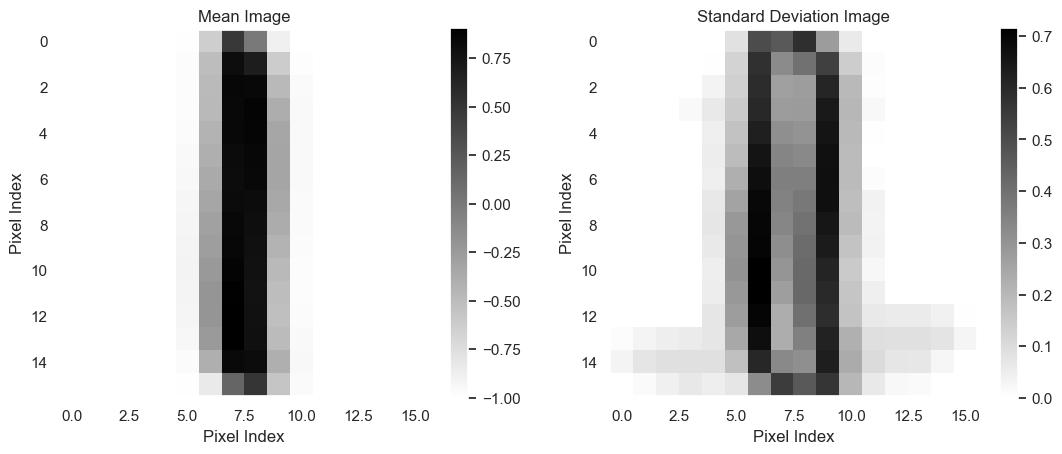

In [351]:
# Load the digits data set
X = np.load('data/digits/X.npy')
y = np.load('data/digits/y.npy')

considered_digits = [1] # Digits to include in analysis (to include all: n = range(10))

# Define a mask to filter the data based on the considered digits
mask = np.isin(y, considered_digits)
# Filter the data based on the mask
X = X[mask]
y = y[mask]

# Compute basic statistics
mean = X.mean(axis=0)
std = X.std(ddof=1, axis=0) # Compute sample standard deviation
cov = np.cov(X, rowvar=0, ddof=1) # Compute sample covariance matrix

fig, axs = plt.subplots(1, 2, figsize=(13, 6))
mean_img = axs[0].imshow(mean.reshape(16, 16), cmap='gray_r')
fig.colorbar(mean_img, ax=axs[0], shrink=0.8)
axs[0].set_title('Mean Image')
axs[0].set_xlabel('Pixel Index')
axs[0].set_ylabel('Pixel Index')
axs[0].grid(False)

std_img = axs[1].imshow(std.reshape(16, 16), cmap='gray_r')
fig.colorbar(std_img, ax=axs[1], shrink=0.8)
axs[1].set_title('Standard Deviation Image')
axs[1].set_xlabel('Pixel Index')
axs[1].set_ylabel('Pixel Index')
axs[1].grid(False)
plt.show()


**Task 5.3:** Does the mean look like you expect? Can you explain why the standard deviation is highest along the edges of the digit one? Try to change the digit you analyze and get a felling of how different the individual digits are.

For each pixel we now have a mean and a standard deviation, i.e., 256 means and 256 corresponding standard deviations. So in essence we can make a a simple model of the digits with a Normal distributions for each individual pixel. Since we know how to draw a new sample from a Normal distribution we can draw a sample for each individual pixel based on their respective 1D normal distribution (i.e. draw a total of 256 values). Combining these samples we end up with a new digit. The question is now how natural our newly generated/artificial samples are, and if they at all are possible to recognize as digits.

**Task 5.4:** Generate 10 new images with the same mean and standard deviation as the data using a 1-dimensional Normal distribution for each pixel.
> *Hint:* An affine transformation of a standard Normal random variable yields a new Normally distributed variable. Specifically, if $\epsilon \sim \mathcal{N}(0, 1)$, then $x = \mu + \sigma \cdot \epsilon$ follows $x \sim \mathcal{N}(\mu, \sigma^2)$.

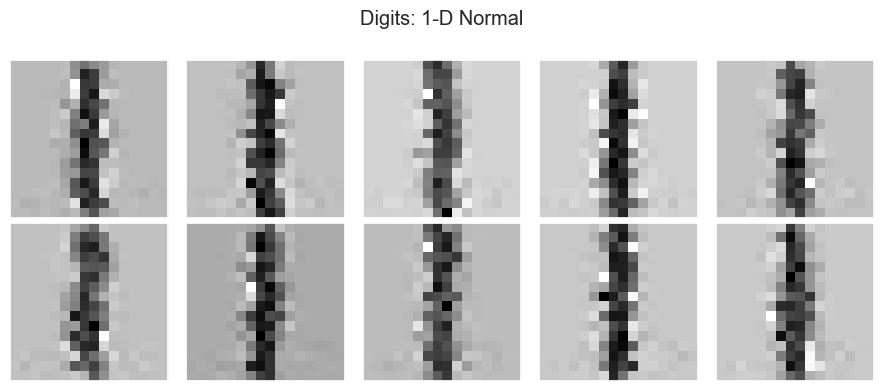

In [352]:
# Number of images of the digit to generate
num_images = 10
# NOTE: make sure to store the generated images in a variable called `generated_images`

# Set up storage for generated images
generated_images = np.zeros((num_images, 256))
# Generate noise samples from 256 1-dimensional Normal distributions
noise_samples = np.random.randn(num_images, 256)
# Scale and shift the noise samples based on the computed mean and standard deviation
for i in range(num_images):
    generated_images[i] = np.multiply(noise_samples[i], std) + mean

### END SOLUTION

# Plot images
fig = plt.figure(figsize=(9, 4))
fig.suptitle("Digits: 1-D Normal")
for k in range(num_images):
    plt.subplot(2, int(np.ceil(num_images / 2.0)), k + 1)
    I = np.reshape(generated_images[k, :], (16, 16))
    plt.imshow(I, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

With our simple model above we argued that we had 256 different 1D Normal distributions; however, we could also look at the problems in terms of the multivariate Normal. Instead of assuming 256 independent 1D Gaussians we could formulate our model for digits as a 256-dimensional multivariate Normal, which allows each pixel to depend on the other pixels. This dependency is described through the covariance matrix.

**Task 5.5:** generate 10 new images with the same mean and covariance as the data using a $16\times16 = 256$-dimensional multivariate Normal distribution. Which model is best? Try changing the analyzed digits and see what happens.

**Task 5.6:** (Extra challenge) Try to vary the number of observations of a given digit you use to estimate the mean and (co)variance. Does the number of observations used make a difference on the quality of the generated digits?

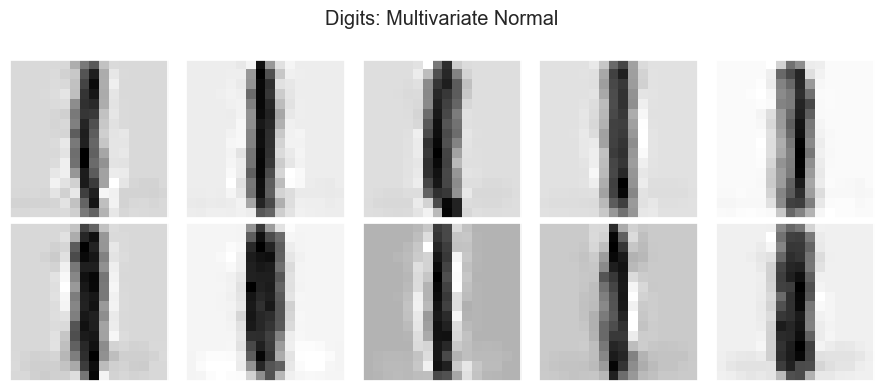

In [353]:

# Generate 10 samples from multivariate normal distribution
generated_images_multivariate = np.random.multivariate_normal(mean, cov, num_images)
# Note if you are investigating a single class, then you may get:
# """RuntimeWarning: covariance is not positive-semidefinite."""
# Which in general is troublesome, but here is due to numerical imprecission


# Plot images
fig = plt.figure(figsize=(9, 4))
fig.suptitle("Digits: Multivariate Normal")
for k in range(num_images):
    plt.subplot(2, int(np.ceil(num_images / 2.0)), k + 1)
    I = np.reshape(generated_images_multivariate[k, :], (16, 16))
    plt.imshow(I, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

#### Advanced (optional): Training a Bayes and Naive Bayes classifier to distinguish between digits

Essentially, what we modeled above is the likelihood $p(x_1, x_2, \dots, x_M | y=c)$ and $p(x_j | y=c)$ for all $j \in \{0, 1, \dots, M\}$ where $i$ denotes the pixel index. This should be familiar to you as we previously studied these quantities when fitting the naive Bayes classifier to the name data set. In the following we will go through how to fit a binary Bayes and Naive Bayes classifier to the digit data set. The solutions relies on writing code that is numerical stable for which reason we provide the solution. Please make sure you understand the code and feel free to implement it yourself as a practice afterwards.

We start by loading data for the two digits that we want to classify between.

In [354]:
digits = [0, 8] # Digits to classify between
assert len(digits) == 2, "This code should only classify between two digits!"

# Load the data
X = np.load('data/digits/X.npy')
y = np.load('data/digits/y.npy')

# Filter the data for the two digits
mask = np.isin(y, digits)
y = y[mask]
X = X[mask]
order = y.argsort()
y = y[order]
X = X[order]

Unfortunately, computing the posterior probabilities as is results in numerical issues that all relates to multiplying or dividing by small numbers. As an example, consider the naive Bayes likelihood that takes the product of $M$ pixel-wise likelihoods, i.e.
$$
    p(\boldsymbol{x}| y) = \prod_{j=1}^M p(x_j |y)
$$
If many of the pixel-wise likelihood values are small, this likelihood diminishes which is one cause for numerical instability. However, we know from standard mathematics that the above product can easily be turned into a sum by taking the logarithm, i.e.:
$$
    \log p(\boldsymbol{x}| y) = \log \prod_{j=1}^M p(x_j |y) = \sum_{j=1}^M \log p(x_j |y)
$$
This is a more stable alternative to the multiplication version. To counter the instability problem, we therefore consider modeling the *log-posterior* rather than the posterior. Applying the logarithm to Bayes' theorem (and using the same logarithm rule), we get:
$$
\begin{align}
    \log p(y|\boldsymbol{x}) &= \log\left(\frac{p(\boldsymbol{x}|y) p(y)}{\sum_{k=1}^K p(\boldsymbol{x}|y=k) p(y=k)}\right) = \log p(\boldsymbol{x}|y) + \log p(y) - \log \left( \sum_{k=1}^K p(\boldsymbol{x}|y=k) p(y=k) \right)
\end{align}
$$
As you see, the log-denominator term still consists of a product between the likelihood and prior, so if we wish to be numerically stable, we need to transform this product somehow. We consider the very simple trick of applying $\exp \left(\log\left(\cdot\right)\right)$ as these operations are each others inverse, which gives:
$$
\begin{align}
    \log p(y|\boldsymbol{x}) &= \log p(\boldsymbol{x}|y) + \log p(y) - \log \left( \sum_{k=1}^K \exp \bigl( \log p(\boldsymbol{x}|y=k) + \log p(y=k)\bigr) \right)
\end{align}
$$
Now we can exploit the so-called $\operatorname{LogSumExp}$ trick ([see here for a reference](https://en.wikipedia.org/wiki/LogSumExp)) on the log-joint terms for computing the log-denominator in a numerical stable way. In practice we do this using `scipy.special.logsumexp`. After all the computational work is done, we can easily map the log-posterior back to a probability value by taking the expectation since $p(y|\boldsymbol{x}) = \exp \left(\log p(y|\boldsymbol{x})\right)$. We can then use this as a classification criteria, e.g. $p(y=1|\boldsymbol{x}) > p(y=0|\boldsymbol{x})$. In the below cell we first compute the log-joint for each class using the full Bayes likelihood and naive Bayes likelihood - we do so for all points in the data set. Next, we compute the log-denominator and log-posteriors for each method on all data points before we lastly predict the label and plot the posterior probability of each sample in the data set to belong to the positive class.


=== Bayes with full covariance  method (accuracy) ===
     Acc. on digit 0: 	99.92%
     Acc. on digit 8: 	100.00%
-->  Total acc.: 	99.94%

=== Naive Bayes with independence assumption method (accuracy) ===
     Acc. on digit 0: 	85.59%
     Acc. on digit 8: 	98.52%
-->  Total acc.: 	89.63%


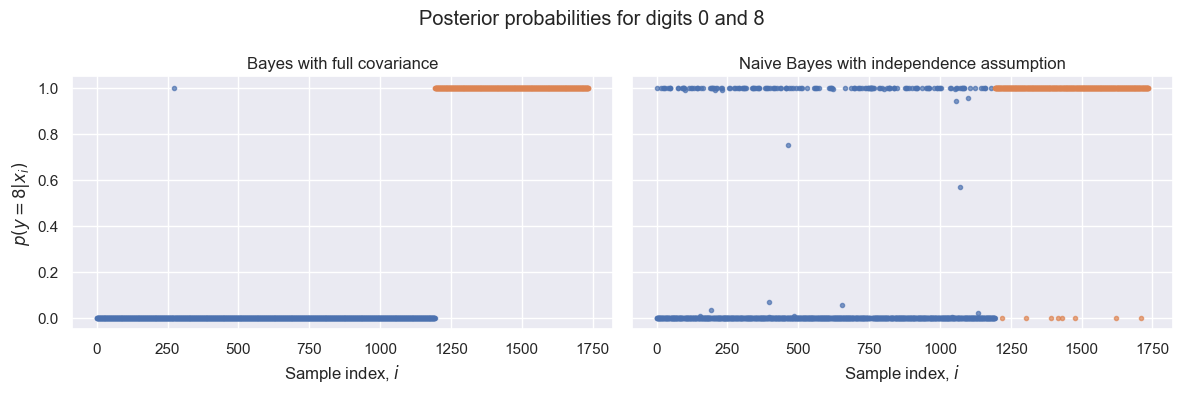

In [355]:
from scipy.special import logsumexp

### COMPUTE LOG-JOINT PROBABILITIES ###
log_joints = {}
for digit in digits:
    X_digit = X[y == digit, :]
    # Compute the empirical mean and covariance matrix for the digit
    mean_digit = X_digit.mean(axis=0)
    std_digit = X_digit.std(ddof=1, axis=0) + 1e-6 # add small value to avoid division by zero
    cov_digit = np.cov(X_digit, rowvar=0, ddof=1) + 1e-6 * np.eye(X_digit.shape[1])  # Add small value to diagonal for numerical stability

    # Compute the log prior for the digit
    log_prior = np.log(np.sum(y == digit) / len(y))
    # Compute the log-likelihood for the digit
    log_likelihood = stats.multivariate_normal.logpdf(X, mean=mean_digit, cov=cov_digit, allow_singular=True)
    # Compute the log-likelihood for the digit under the assumption of independence
    log_likelihood_naive = np.sum(stats.norm.logpdf(X, loc=mean_digit, scale=std_digit), axis=1)
    
    # Compute the log joint probability
    log_joints[digit] = {
        'bayes': log_likelihood + log_prior,
        'naive': log_likelihood_naive + log_prior
    }

### COMPUTE THE LOG-POSTERIORS FOR EACH METHOD IN A NUMERICALLY STABLE WAY ###
# Compute the log denominator using logsumexp trick
log_denominators = {k: logsumexp([log_joints[digit][k] for digit in digits], axis=0) for k in ['bayes', 'naive']}
# Compute the log posterior probabilities
log_posteriors = {k: {digit: log_joints[digit][k] - log_denominators[k] for digit in digits} for k in ['bayes', 'naive']}



### EVALUATE THE PERFORMANCE AND PLOT THE POSTERIOR PROBABILITIES ###

for method in ['bayes', 'naive']:
    method_name = 'Bayes with full covariance ' if method == 'bayes' else 'Naive Bayes with independence assumption'
    print(f"\n=== {method_name} method (accuracy) ===")

    # We predict by considering the digit with highest log-posterior probability.
    # Since log is a monotonic function, we can use argmax on the log posteriors and get the same result as if we had used the posteriors directly.
    y_pred = np.argmax([log_posteriors[method][digit] for digit in digits], axis=0)
    # Convert the predicted labels to the original digit labels using a map
    mapping = {i: digit for i, digit in enumerate(digits)}
    lookup = np.array([mapping[0], mapping[1]])
    y_pred = lookup[y_pred]

    # Compute class-wise accuracy
    for digit in digits:
        class_accuracy = np.mean(y_pred[y == digit] == digit)
        print(f"     Acc. on digit {digit}: \t{class_accuracy:.2%}")

    # Compute the total accuracy
    accuracy = np.mean(y_pred == y)
    print(f"-->  Total acc.: \t{accuracy:.2%}")

# Plot the posterior probability of the postive class (digit 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle(f"Posterior probabilities for digits {digits[0]} and {digits[1]}")
# Color by true label
for digit in digits:
    # We select the indices of the samples that belong to the current digit
    digit_indices = np.where(y == digit)[0]
    # We map the log posteriors to probabilities using exp and plot the results
    axs[0].plot(digit_indices, np.exp(log_posteriors['bayes'][digits[1]][digit_indices]), '.', alpha=0.7, label=f'Digit {digit}')
    axs[1].plot(digit_indices, np.exp(log_posteriors['naive'][digits[1]][digit_indices]), '.', alpha=0.7, label=f'Digit {digit}')

axs[0].set_title('Bayes with full covariance')
axs[0].set_xlabel(r'Sample index, $i$')
axs[0].set_ylabel(rf'$p\left(y={digits[1]}|x_i\right)$')
axs[1].set_title('Naive Bayes with independence assumption')
axs[1].set_xlabel(r'Sample index, $i$')
plt.tight_layout()
plt.show()

**Task 5.7 (optional):** Try to change the considered digits into some that are less distinct than [0,1], e.g. 0 vs. 8 or 4 vs. 9. How does this impact the performance of the two approaches?

**Task 5.8 (optional):** Feel free to play around with your own implementation. As an exercise you can consider trying to model the posterior directly (i.e. not the log-posterior) and verify that the solution is numerically unstable.